In [1]:
import pandas as pd
import numpy as np
import os
import missingno as msno
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
description = pd.read_csv('../input/HomeCredit_columns_description.csv')

In [2]:
description[description.Row == 'AMT_REQ_CREDIT_BUREAU_QRT'].Description.iloc[0]

'Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)'

In [3]:
description[description.Row == 'APARTMENTS_MEDI'].Description.iloc[0]


'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'

In [100]:
def read_df(name):
    if os.path.exists('../input/%s.h5' %name):
        df = pd.read_hdf('../input/%s.h5' %name, str(name))
    else:
        df = pd.read_csv('../input/%s.csv' %name)
        df.to_hdf('../input/%s.h5' %name, str(name))
    return df

#-----------------------------------
# Read data and merge
#-----------------------------------
df = read_df('application_train')
test_df = read_df('application_test')
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()

#-----------------------------------
# simple processing
#-----------------------------------

# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

#-----------------------------------
# age
#-----------------------------------
df['age'] = df['DAYS_BIRTH'] / -365.0
df['is_age_betwee_20_and_25'] = df.age.apply(lambda x: 1.0 if 20 < x <= 25.0 else 0)
df['is_age_betwee_25_and_30'] = df.age.apply(lambda x: 1.0 if 25 < x <= 30.0 else 0)
df['is_age_betwee_30_and_35'] = df.age.apply(lambda x: 1.0 if 30 < x <= 35.0 else 0)
df['is_age_betwee_35_and_40'] = df.age.apply(lambda x: 1.0 if 35 < x <= 40.0 else 0)
df['is_age_betwee_40_and_45'] = df.age.apply(lambda x: 1.0 if 40 < x <= 45.0 else 0)
df['is_age_betwee_45_and_50'] = df.age.apply(lambda x: 1.0 if 45 < x <= 50.0 else 0)
df['is_age_above_50'] = df.age.apply(lambda x: 1.0 if x >= 50.0 else 0)


#-----------------------------------
# 在這次申請貸款之前幾年, 這個人開始現在的工作。如是0.5, 這個人這次申請這貸款前半年開始他現在這份工作。
#-----------------------------------
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] / -365.0
df['maybe_they_have_no_job_before_half_year'] = df.YEARS_EMPLOYED.apply(lambda x: 1 if x <=0.5 else 0)
df['maybe_they_have_no_job_before_1_or_half_year'] = df.YEARS_EMPLOYED.apply(lambda x: 1 if 0.5 <= x <=1.0 else 0)
df['they_must_do_other_thing_to_survive'] = df.YEARS_EMPLOYED.apply(lambda x: 1 if x > 1 else 0)

#-----------------------------------
# 大學剛畢業就有車有房還貸款, 肯定裝逼, 還不起。
#-----------------------------------
df['fresh_have_car'] = [1 if (age < 22) and (have_car == 'Y') else 0 for have_car, age in zip(df.FLAG_OWN_CAR, df.age)]
df['fresh_have_house'] = [1 if (age < 22) and (have_house == 'Y') else 0 for have_house, age in zip(df.FLAG_OWN_REALTY, df.age)]
df['fresh_have_house_and_car'] = [1 if (age < 22) and (have_house == 'Y') and (have_car == 'Y') else 0 for have_house,have_car,age in zip(df.FLAG_OWN_REALTY, df.FLAG_OWN_CAR,df.age)]
#-----------------------------------
# 老人沒車沒房還貸款, 肯定高危險份子,還不起。
#-----------------------------------

df['old_no_car'] = [1 if (age > 50) and (have_car == 'N') else 0 for have_car, age in zip(df.FLAG_OWN_CAR, df.age)]
df['old_no_house'] = [1 if (age > 50) and (have_house == 'N') else 0 for have_house, age in zip(df.FLAG_OWN_REALTY, df.age)]
df['old_no_house_and_car'] = [1 if (age > 50) and (have_house == 'N') and (have_car == 'N') else 0 for have_house,have_car,age in zip(df.FLAG_OWN_REALTY, df.FLAG_OWN_CAR,df.age)]
#-----------------------------------
#save 
#-----------------------------------
output = ['SK_ID_CURR'] \
+ [f for f in df.columns.tolist() if ('age' in f) or ('year') in f] \
+ ['YEARS_EMPLOYED','they_must_do_other_thing_to_survive'] \
+ [f for f in df.columns.tolist() if 'fresh' in f] \
+ [f for f in df.columns.tolist() if 'old_no' in f]

Train samples: 307511, test samples: 48744


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [29]:
features_want_to_explore = ['SK_ID_CURR'] \
+ [f for f in df.columns.tolist() if ('age' in f) or ('year') in f] \
+ ['YEARS_EMPLOYED','they_must_do_other_thing_to_survive'] \
+ [f for f in df.columns.tolist() if 'fresh' in f] \
+ [f for f in df.columns.tolist() if 'no' in f]

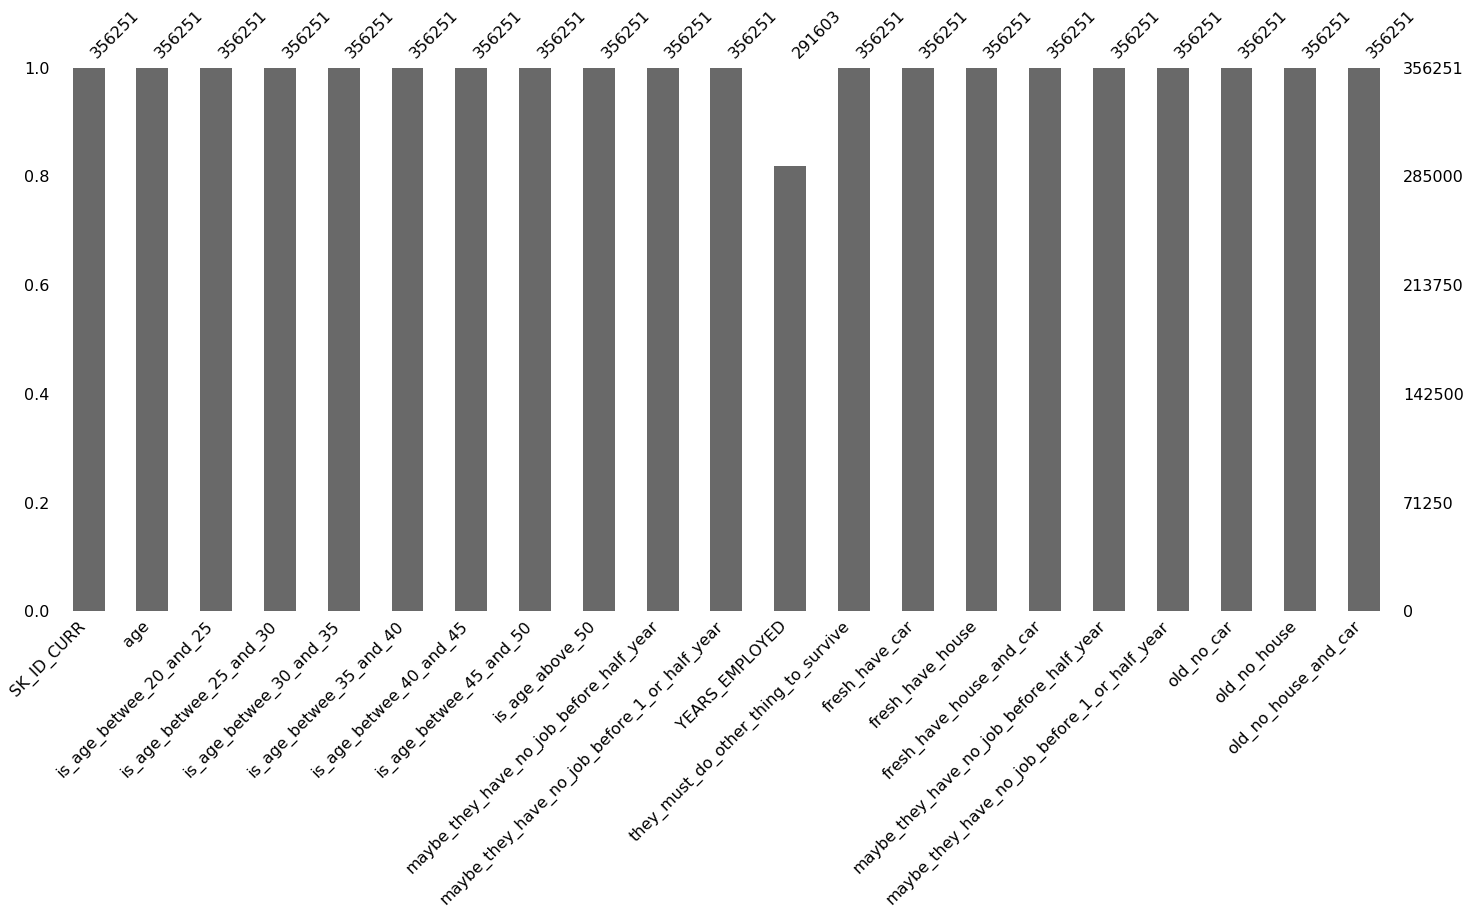

In [31]:
msno.bar(df[features_want_to_explore])

['SK_ID_CURR',
 'age',
 'is_age_betwee_20_and_25',
 'is_age_betwee_25_and_30',
 'is_age_betwee_30_and_35',
 'is_age_betwee_35_and_40',
 'is_age_betwee_40_and_45',
 'is_age_betwee_45_and_50',
 'is_age_above_50',
 'maybe_they_have_no_job_before_half_year',
 'maybe_they_have_no_job_before_1_or_half_year',
 'they_must_do_other_thing_to_survive',
 'fresh_have_car',
 'fresh_have_house',
 'fresh_have_house_and_car',
 'maybe_they_have_no_job_before_half_year',
 'maybe_they_have_no_job_before_1_or_half_year',
 'old_no_car',
 'old_no_house',
 'old_no_house_and_car']

# pair plot may help u to position what are useful features bue we need a qunatitive value to judge ===>分佈非重疊面積越大代表這個feature越有鑑別力(?)
# can pack the below as feature_exporing function in utils.py
# Reference: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

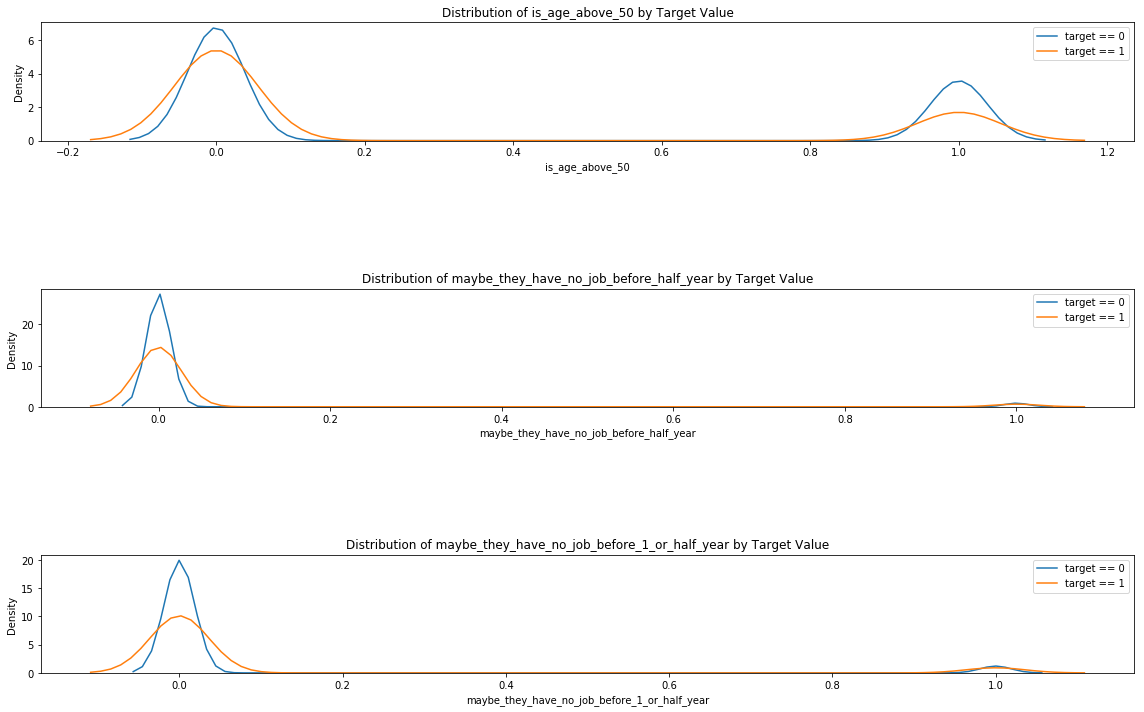

In [101]:
plt.rcParams['figure.figsize'] = [16, 10]

# iterate through the features we want to visualize(remove fields with nan)
features_want_to_explore = ['is_age_above_50',
 'maybe_they_have_no_job_before_half_year',
 'maybe_they_have_no_job_before_1_or_half_year',]

for i, features in enumerate(features_want_to_explore):
    # create a new subplot for each source
    plt.subplot(len(features_want_to_explore), 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, features], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, features], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of {} by Target Value'.format(features))
    plt.xlabel('{}'.format(features))
    plt.ylabel('Density');
    
plt.tight_layout(h_pad = 10)

In [104]:
df.dropna(subset = ['TARGET'],inplace = True)

In [105]:
df['fake_feature'] = [10 if t == 1 else 5 for t in df.TARGET.tolist()]

In [107]:
df[['TARGET', 'fake_feature']]

,TARGET,fake_feature
0,1.0,10
1,0.0,5
2,0.0,5
3,0.0,5
4,0.0,5
5,0.0,5
6,0.0,5
7,0.0,5
8,0.0,5
9,0.0,5


LinAlgError: singular matrix

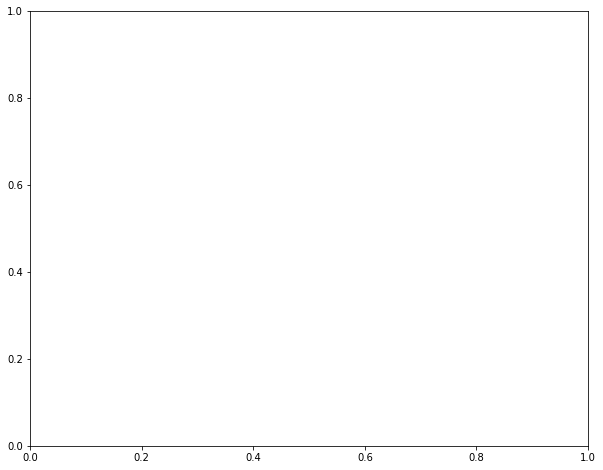

In [108]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 0, 'fake_feature'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'fake_feature'] , label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


In [62]:
# Conditional that returns a boolean Series with column labels specified
df.loc[df['TARGET'] == 1, 'DAYS_BIRTH']

0         -9461
26       -18724
40       -17482
42       -13384
81       -24794
94       -10199
110      -10526
138      -16667
154      -17538
163       -7989
180      -15326
184      -10127
211      -12824
235      -23127
242       -9157
246      -17847
255      -11356
260      -12209
261       -8292
283      -22078
291      -13989
344      -13707
348      -20200
368      -18302
381       -8038
389      -18767
408      -13923
413      -13715
419      -11353
424       -9684
          ...  
307123   -10989
307126    -9542
307133   -13915
307162   -17051
307177   -12788
307183   -13155
307248    -9879
307256   -18720
307266   -18125
307268    -9170
307283   -22430
307285   -16597
307288   -11213
307310   -22461
307323   -16998
307328   -13612
307363   -20086
307377   -10609
307383   -12460
307386   -20492
307407   -11407
307410   -15520
307433   -10873
307438   -11275
307446   -10130
307448    -9918
307475   -13416
307481   -20644
307489   -16471
307509   -11961
Name: DAYS_BIRTH, Length